In [1]:
import os
from transformers import BlipProcessor, BlipForQuestionAnswering
import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import json
from torch.linalg import vector_norm
from transformers import BertTokenizer, BertModel
import IPython
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

In [2]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained('bert-base-uncased')

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [3]:
def get_cosine_sim(sentences_pred, sentences_true):

    def get_embedding(sentence):
        encoding = tokenizer.batch_encode_plus(sentence, padding=True, truncation=True, return_tensors='pt', add_special_tokens=True)
        input_ids = encoding['input_ids']
        attention_mask = encoding['attention_mask']
        with torch.no_grad():
            outputs = bert(input_ids, attention_mask=attention_mask)
            word_embeddings = outputs.last_hidden_state
        return word_embeddings
    
    emb_pred = get_embedding(sentences_pred).squeeze().mean(dim=0)
    emb_true = get_embedding(sentences_true).squeeze().mean(dim=0)
    cosine_sim = torch.sum(emb_pred * emb_true) / (vector_norm(emb_pred) * vector_norm(emb_true))

    return cosine_sim

def validate(model, valid_dataloader):
    model.eval()
    mean_cosine = torch.empty(len(valid_dataloader.dataset))
    with torch.no_grad():
        for i, batch in enumerate(tqdm(valid_dataloader, desc='Validating')):
            input_ids = batch['input_ids'].to(device)
            pixel_values = batch['pixel_values'].to(device)
            attention_masked = batch['attention_mask'].to(device)
            generated_ids = model.generate(input_ids=input_ids, attention_mask=attention_masked, pixel_values=pixel_values, max_length=50)
            generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)
            mean_cosine[i] = get_cosine_sim(generated_caption, batch['answer'])
    return mean_cosine.mean()

В качестве модели взял BLIP. В архитектуру входит image encoder, text encoder, image-grounded text encoder и image-grounded text decoder. Сначала вычисляются эмбеддинги картинки, затем в text encoder вычисляются эмбеддинги текста, далее сам текст и эти вычисленные эмбеддинги используются в cross-attention слое image-grounded text encoder. В image-grounded text decoder уже используются эмбеддинги всех трех предыдущих блоков в cross-attention.

Первые два энкодера обучаются с помощью image-text contrastive лосса, image-grounded text encoder обучается на image-text matching лосс. Декодер обучается с помощью language modeling лосса.

In [4]:
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
model.to(device);

In [7]:
torch.cuda.empty_cache()

Cсылка на датасет: https://huggingface.co/datasets/Peppertuna/ChartQADatasetV2

Я выбрал этот датасет потому, что там есть ручная разметка от людей. В некоторых других я заметил, что данные могли быть размечены какой-то моделью (в основном GPT-4). Здесь такое тоже есть, но отдельно выделено. Так же он довольно большой. Так же модель училась не нем изначально.

In [28]:
class VQADataset(Dataset):

    def __init__(self, processor, type_='train'):
        self.type = type_
        path2dataset = os.path.join("ChartQA Dataset", type_)
        self.base_path2pic = os.path.join(path2dataset, 'png')
        with open(os.path.join(path2dataset, f"{type_}_human.json"), 'r') as file:
            human = json.load(file)
        self.annotations = human
        self.processor = processor

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        
        question = self.annotations[idx]['query']
        answer = self.annotations[idx]['label']
        image_name = self.annotations[idx]['imgname']
        image_path = os.path.join(self.base_path2pic, image_name)
        image = Image.open(image_path)
        
        encoding = self.processor(image, question, padding="max_length", truncation=True, return_tensors="pt")
        labels = self.processor.tokenizer.encode(
            answer, max_length=8, return_tensors='pt', padding='max_length', truncation=True
        )
        encoding["labels"] = labels
    
        # убираем размерность батча
        for k, v in encoding.items():
            encoding[k] = v.squeeze()

        encoding["question"] = question
        encoding["answer"] = answer
        encoding["image name"] = image_name
        
        return encoding

In [9]:
train_dataset = VQADataset(processor=processor)
valid_dataset = VQADataset(processor=processor, type_='val')

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=False, pin_memory=True)

В качестве метрики я взял среднее косинусное расстояние, тк, например, bleu не учитывал схожесть цифр - для пар (1, 999), (1, 2) он будет нулевым, хотя понятно, что 2 намного ближе к 1. У WUP-measure возникла проблема с цифрами - их могло не быть с словаре. Эмбеддинги брались у модели BERT

In [11]:
val_metric = validate(model, valid_dataloader).item()
val_metric

Validating: 100%|██████████| 960/960 [01:36<00:00,  9.90it/s]


0.6833809614181519

In [12]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

С mixed-precision обучение проходило быстрее

In [13]:
num_epochs = 3
scaler = torch.cuda.amp.GradScaler()

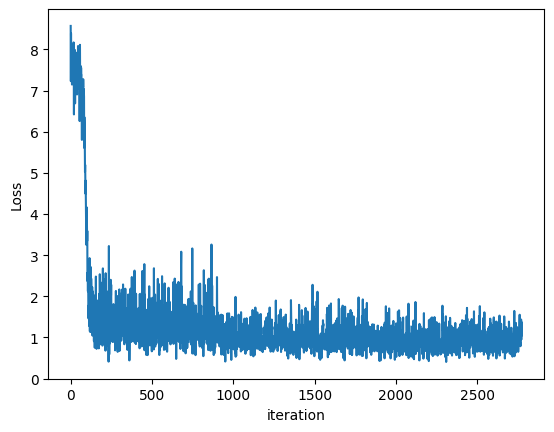

Training batch (last val metric - 0.6963902711868286): 100%|██████████| 925/925 [1:15:12<00:00,  4.88s/it]
Validating: 100%|██████████| 960/960 [03:59<00:00,  4.01it/s]

Validation metric:  0.7115622758865356


In [14]:
loss_hist = []
for epoch in range(num_epochs):
    epoch_loss = 0
    model.train()
    for idx, batch in enumerate(tqdm(train_dataloader, desc=f'Training batch (last val metric - {val_metric})')):
        IPython.display.clear_output(wait=True)
        input_ids = batch['input_ids'].to(device)
        pixel_values = batch['pixel_values'].to(device)
        attention_masked = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        
        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(input_ids=input_ids,
                        pixel_values=pixel_values,
                        attention_mask=attention_masked,
                        labels=labels)

        loss = outputs.loss
        epoch_loss += loss.item()
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        loss_hist.append(loss.item())
        plt.ylabel('Loss')
        plt.xlabel('iteration')
        plt.plot(loss_hist)
        plt.show()
    scheduler.step()
    val_metric = validate(model, valid_dataloader).item()
    print("Validation metric: ", val_metric)

Стало чуть лучше чем до дообучения

In [29]:
test_dataset = VQADataset(processor=processor, type_='test')

In [30]:
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, pin_memory=True)

In [31]:
model.eval();

In [40]:
answers = {"image names": [], "questions": [], "answers": []}
with torch.no_grad():
    for i, batch in enumerate(tqdm(test_dataloader, desc='Testing')):
        input_ids = batch['input_ids'].to(device)
        pixel_values = batch['pixel_values'].to(device)
        attention_masked = batch['attention_mask'].to(device)
        image_name = batch['image name']
        generated_ids = model.generate(input_ids=input_ids, attention_mask=attention_masked, pixel_values=pixel_values, max_length=50)
        generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)
        answers["image names"].extend(image_name)
        answers["answers"].extend(generated_caption)
        answers["questions"].extend(batch['question'])

Testing: 100%|██████████| 157/157 [09:13<00:00,  3.52s/it]


In [41]:
import pandas as pd

In [42]:
df = pd.DataFrame(answers)
df

,image names,questions,answers
0,41699051005347.png,How many food item is shown in the bar graph?,4
1,41699051005347.png,What is the difference in value between Lamb a...,0. 4
2,41810321001157.png,How many bars are shown in the chart?,2
3,41810321001157.png,Is the sum value of Madagascar more then Fiji?,yes
4,8127.png,What's the value of the lowest bar?,0. 6
...,...,...,...
1245,multi_col_60916.png,What is the average of 2010 data?,0. 5
1246,multi_col_60688.png,Which catogory has the highest value in C1?,no
1247,multi_col_60688.png,What is the largest value of red bar?,0. 6
1248,multi_col_100695.png,Which year has lowest Share of individuals who...,2019


In [43]:
df.to_csv('answers.csv', index=False)